# Predicting zeolite deprotonation energies via neural networks
This notebook gives examples on how to use the size of the rings associated with oxygen sites, tetrahedral sites, and entire zeolite frameworks to predict the deprotonation energy (DPE) of each proton location in these  frameworks.\
Ring data was found using Zeolite Simulation Environment (zse), github.com/jtcrum/zse \
The DPE data comes from A. Jones and E. Iglesia, ACS Catal. 2015, 5, 5741−5755

In [1]:
import numpy as np
import torch
from torch.autograd import Variable
import torch.nn.functional as F
import torch.utils.data as Data
import matplotlib.pyplot as plt
%matplotlib inline

# Reproducibility Information
Ring data was found using ZSE commit: 5a52d2\
Function to get O rings: zse.rings.get_orings_new()\
Function to get T-site rings: zse.rings.get_trings()\
Function to get framework rings: zse.rings.get_unique_rings()

# Test Full Data Set

In [2]:
# read x data (ring feature list)

x_data = np.loadtxt('full_data/x_values.csv', delimiter = ',', dtype = float)

# read y data (deprotonation energies)

y_data = np.loadtxt('full_data/y_values.csv',delimiter = ',', dtype = float, ndmin = 2)

In [3]:
# convert data to torch tensors

x_data = torch.tensor(x_data)
x_data = Variable(x_data)

y_data = torch.tensor(y_data)
y_data = Variable(y_data)


In [4]:
# Set network seed for reproducability

torch.manual_seed(1);

# Define the network class

class Net(torch.nn.Module):
    def __init__(self, n_feature, n_hidden, n_output):
        super(Net, self).__init__()
        self.hidden = torch.nn.Linear(n_feature, n_hidden)
        self.predict = torch.nn.Linear(n_hidden, n_output)
        
    def forward(self,x):
        x = F.softsign(self.hidden(x))
        x = self.predict(x)
        return x
    
# Define our network

net = Net(n_feature = len(x_data[0]), n_hidden = 60, n_output=1)

# Define our optimizer

optimizer = torch.optim.Rprop(net.parameters(), lr = .0002)

# Define our loss function (mean squared error)
loss_func = torch.nn.MSELoss()

In [5]:
# Train the network

for t in range(1000):
    prediction = net(x_data.float())

    loss = loss_func(prediction,y_data.float())
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()
    

training loss =  0.00016855806461535394


/afs/crc.nd.edu/user/j/jcrum/anaconda3/lib/python3.7/site-packages/matplotlib/figure.py:445: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.
  % get_backend())


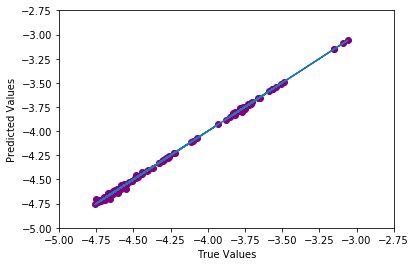

In [6]:
# print loss value

print('training loss = ',loss.item())

# plot the training data

fig = plt.figure()
ax = fig.add_subplot(111)
ax.plot(y_data,y_data)
ax.scatter(y_data,prediction.data.numpy(),c='purple',label='Training Points')
ax.set_ylim([-5,-2.75])
ax.set_xlim([-5,-2.75])
ax.set_xlabel('True Values')
ax.set_ylabel('Predicted Values')
fig.show()

# 75% Training / 25% Validating
One proton location from each T Site is removed from the training data, and added to the validating data.\
This data was preseparated in processing_raw_data_into_features.ipynb.

In [7]:
# Read x data (ring feature list)

x_train = np.loadtxt('one_per_T/x_train.csv', delimiter = ',', dtype = float)
x_validate = np.loadtxt('one_per_T/x_validate.csv', delimiter = ',', dtype = float)

# Read y data (deprotonation energies)

y_train = np.loadtxt('one_per_T/y_train.csv',delimiter = ',', dtype = float, ndmin = 2)
y_validate = np.loadtxt('one_per_T/y_validate.csv',delimiter = ',', dtype = float, ndmin = 2)

In [8]:
# Convert to torch tensors

x_train = torch.tensor(x_train)
x_train = Variable(x_train)

x_validate = torch.tensor(x_validate)
x_validate = Variable(x_validate)

y_train = torch.tensor(y_train)
y_train = Variable(y_train)

y_validate = torch.tensor(y_validate)
y_validate = Variable(y_validate)

In [9]:
# Set network seed for reproducability

torch.manual_seed(1);

# Define the network class

class Net(torch.nn.Module):
    def __init__(self, n_feature, n_hidden, n_output):
        super(Net, self).__init__()
        self.hidden = torch.nn.Linear(n_feature, n_hidden)
        self.predict = torch.nn.Linear(n_hidden, n_output)
        
    def forward(self,x):
        x = F.softsign(self.hidden(x))
        x = self.predict(x)
        return x
    
# Define our network

net = Net(n_feature = len(x_train[0]), n_hidden = 60, n_output=1)

# Define our optimizer

optimizer = torch.optim.Rprop(net.parameters(), lr = .0002)

# Define our loss function (mean squared error)

loss_func = torch.nn.MSELoss()

In [10]:
# Train the network

for t in range(1000):
    prediction = net(x_train.float())

    loss = loss_func(prediction,y_train.float())
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

training loss =  0.00011217526480322704
validating loss =  0.0194920115172863


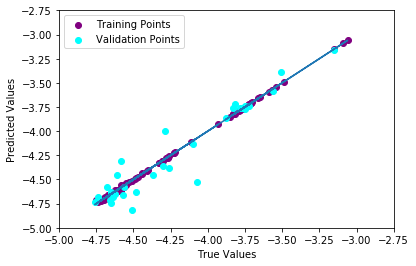

In [11]:
# print loss value

print('training loss = ',loss.item())

# plot the training data

fig = plt.figure()
ax = fig.add_subplot(111)
ax.plot(y_data,y_data)
ax.scatter(y_train,prediction.data.numpy(),c='purple',label='Training Points')
ax.set_ylim([-5,-2.75])
ax.set_xlim([-5,-2.75])
ax.set_xlabel('True Values')
ax.set_ylabel('Predicted Values')

# Predict the validating data

prediction = net(x_validate.float())
loss = loss_func(prediction,y_validate.float())

# print loss values and plot validating data

print('validating loss = ', loss.item())
ax.scatter(y_validate,prediction.data.numpy(),c='cyan',label='Validation Points')
#ax.axis('square')
#ax.set_aspect('equal',adjustable='box')
ax.legend(loc='best')
fig.show()

# Random 70% Training / 30% Validating
Fully random splitting of the entire data set. 

In [12]:
# Read x data (ring feature list)

x_train = np.loadtxt('random_30/x_train.csv', delimiter = ',', dtype = float)
x_validate = np.loadtxt('random_30/x_validate.csv', delimiter = ',', dtype = float)

# Read y data (deprotonation energies)

y_train = np.loadtxt('random_30/y_train.csv',delimiter = ',', dtype = float, ndmin = 2)
y_validate = np.loadtxt('random_30/y_validate.csv',delimiter = ',', dtype = float, ndmin = 2)

In [13]:
# Convert to torch tensors

x_train = torch.tensor(x_train)
x_train = Variable(x_train)

x_validate = torch.tensor(x_validate)
x_validate = Variable(x_validate)

y_train = torch.tensor(y_train)
y_train = Variable(y_train)

y_validate = torch.tensor(y_validate)
y_validate = Variable(y_validate)

In [14]:
# Set network seed for reproducability

torch.manual_seed(1);

# Define the network class

class Net(torch.nn.Module):
    def __init__(self, n_feature, n_hidden, n_output):
        super(Net, self).__init__()
        self.hidden = torch.nn.Linear(n_feature, n_hidden)
        self.predict = torch.nn.Linear(n_hidden, n_output)
        
    def forward(self,x):
        x = F.softsign(self.hidden(x))
        x = self.predict(x)
        return x
    
# Define our network

net = Net(n_feature = len(x_train[0]), n_hidden = 60, n_output=1)

# Define our optimizer

optimizer = torch.optim.Rprop(net.parameters(), lr = .0002)

# Define our loss function (mean squared error)

loss_func = torch.nn.MSELoss()

In [15]:
# Train the network

for t in range(1000):
    prediction = net(x_train.float())

    loss = loss_func(prediction,y_train.float())
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

training loss =  3.1470444810111076e-05
validating loss =  0.020823581144213676


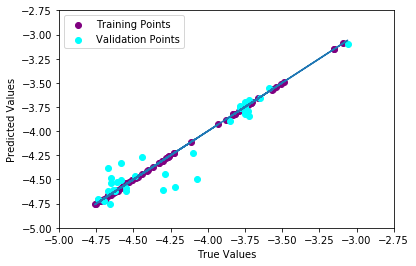

In [16]:
# print loss value

print('training loss = ',loss.item())

# plot the training data

fig = plt.figure()
ax = fig.add_subplot(111)
ax.plot(y_data,y_data)
ax.scatter(y_train,prediction.data.numpy(),c='purple',label='Training Points')
ax.set_ylim([-5,-2.75])
ax.set_xlim([-5,-2.75])
ax.set_xlabel('True Values')
ax.set_ylabel('Predicted Values')

# Predict the validating data

prediction = net(x_validate.float())
loss = loss_func(prediction,y_validate.float())

# print loss values and plot validating data

print('validating loss = ', loss.item())
ax.scatter(y_validate,prediction.data.numpy(),c='cyan',label='Validation Points')
#ax.axis('square')
#ax.set_aspect('equal',adjustable='box')
ax.legend(loc='best')
fig.show()